## Observations

Month is not a useful variable. Try Quarter.
Best result so far is decision tree with df[['Exterior Wall', 'Fixtures', 'Neighborhood', 'Story Height', 'Assessment Ratio', 'Building Grade', 'Quarter']]

Lots of outliers here, try RandomForest

With LightGBM, untuned, got to 33.7

## Next step: incorporate data from full dataframe.

Possibly: average fixtures per house in the neighborhood?

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [9]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#Correcting badly-entered data
df1.loc[176025, 'Sale Price'] = 37000
df1.loc[27056, 'Sale Price'] = 161000
df1.loc[191004, 'Sale Price'] = 810000
df1.loc[239278, 'Sale Price'] = 280395
df1.loc[138891, 'Sale Price'] = 200000
df1.loc[241961, 'Sale Date'] = '2019-03-04'
df1.loc[241961, 'Sale Date'] = pd.to_datetime(df1.loc[241961, 'Sale Date'])
df1.loc[241961, 'Sale Price'] = 370000
df1.loc[230115, 'Sale Price'] = 325000
df1.loc[53151, 'Sale Price'] = 310900
df1.loc[259815, 'Sale Price'] = 1513142
df1.loc[129682, 'Sale Price'] = 1300000
df1.loc[154271, 'Square Footage Improved'] = 10094
df1.drop(190142, inplace=True) #Has a massive ADU ~4 times the size of the 'main' structure. Main struct is low-grade, ADU is luxury.
df1.drop(128094, inplace=True) #Can't find out anything about this house. Improbably large sqft and acreage, low price.

In [11]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()
#Dropping a few outliers
df=df[df.Fixtures <=23]
df=df[df['Land Area Acres'] <=8]
df=df[df.PPS <= 750]

In [12]:
TYPEDICT = {'HIGHRISE APT': 'HRISE', 'APARTMENT': 'CONDO', 'HRISE CONDO': 'HRISE',
            'RESD CONDO': 'CONDO', 'RW SING FAM': 'SINGLE FAM', 'SINGLE FAM': 'SINGLE FAM',
            'RZ SING FAM': 'SINGLE FAM', 'RH SING FAM': 'SINGLE FAM',
            'RY SING FAM': 'SINGLE FAM', 'MODULAR HOME': 'SINGLE FAM',
            'SING FAM': 'SINGLE FAM', 'RESD TRIPLEX': 'PLEX', 'RESD QUADPLX': 'PLEX',
            'R1 DUPLEX': 'PLEX', 'RES DUPLEX': 'PLEX', 'LODGE/FRAT\'L': 'THIRD',
            'CHURCH': 'THIRD', 'HEALTH CLUB': 'COMM', 'GROCERY/SMKT': 'COMM',
            'RETAIL/SHPG': 'COMM', 'DAYCARE': 'COMM', 'MARKET': 'COMM',
            'REST/BAR': 'COMM', 'OFFICE': 'COMM', 'WAREHOUSE': 'COMM',
            'EQUIP SHED': 'COMM', 'SERV GARAGE': 'COMM', 'TRUCK TERM': 'COMM',
            'ZERO LOT': 'VACANT', 'CAR WASH': 'COMM', 'MED OFC': 'COMM',
            'LAUNDRY': 'COMM', 'AUDITORIUM': 'THIRD', 'BANK': 'COMM', 'BOWLING': 'COMM',
            'BUSINESS CTR': 'COMM', 'CINEMA': 'COMM', 'CLUB/UNION': "THIRD",
            "COMM GRNHSE": "COMM", 'WHSE RETAIL': 'COMM', 'ENG/RESEARCH': 'COMM',
            'COUNTRY CLUB': 'THIRD', 'DEPT STORE': 'COMM', 'TENNIS': 'THIRD',
            'WALKUP APT': 'CONDO', 'DRUG STORE': 'COMM', 'DISC STORE': 'COMM',
            'ELDERLY HSG': 'CONDO', "FUNERAL HM": "THIRD", 'SALES SHOWRM': 'COMM',
            'LUMBER': 'COMM', 'MANF PLANT': 'COMM', 'MAINT HANGER': 'COMM',
            'MOTEL': 'COMM', 'MINI-LUBE': 'COMM', 'MINI-WAREHSE': 'COMM',
            'FAST FOOD': 'COMM', 'HOTEL': 'COMM', 'NURSING HOME': 'CONDO', "PARK'G GAR": 'COMM',
            'SERV STATION': 'COMM', 'INDOOR WP': 'COMM', 'HOSPITAL': 'THIRD', 'T-HANGER': 'COMM'
            }

df['Building Type Custom']=df['Building Type'].map(lambda x: TYPEDICT[x] if (x != '' and not pd.isnull(x)) else None)

In [13]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')

In [14]:
df.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
117379,31 N HILL ST,1,10001.0,4.857212,2059.0,SINGLE FAM,Average
87022,5801 MACKIE PL,3,10000.0,6.635700,1507.0,SINGLE FAM,Average
266262,6582 SUNNYWOOD DR,1,15000.0,6.934813,2163.0,SINGLE FAM,Average
210028,4839 JONQUIL DR,1,30000.0,7.812500,3840.0,SINGLE FAM,Average
244774,909 MULBERRY HILL PL,8,28000.0,8.158508,3432.0,SINGLE FAM,Average


In [15]:
df.nlargest(5,'NeighborhoodPPS')[['Neighborhood','NeighborhoodPPS']]

,Neighborhood,NeighborhoodPPS
279631,6264,752.879821
279659,6264,752.879821
279602,6264,752.879821
279632,6264,752.879821
279617,6264,752.879821


In [ ]:
sns.distplot(df['NeighborhoodPPS'].dropna())

In [ ]:
# df['Log Assessment']= df['Land Value Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
# df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
sns.distplot(df['Log Assessment'].dropna())

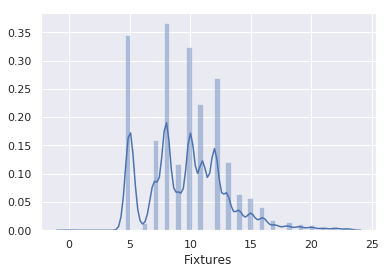

In [18]:
sns.distplot(df['Fixtures'].dropna())

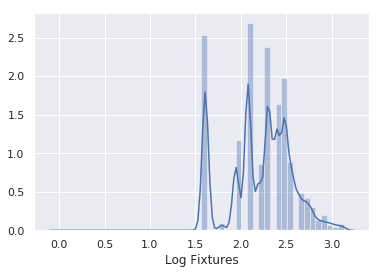

In [70]:
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

In [20]:
df.nlargest(10, 'Land Area Acres')

,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,...,Assessment Ratio,Nbhd Ratio,Month,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land
80374,RES,"$34,425","$31,175","$65,600",2019.0,2.0,3.0,Average,Average,C,...,0.118807,0.054005,10,4,2017,10.347372,2.302585,7.877397,5.358295,2.076938
201384,RES,"$4,025","$24,575","$28,600",2019.0,1.0,NaN,Very Poor,NaN,D,...,0.214816,0.138705,8,3,2015,10.109485,1.609438,6.740519,4.937921,2.046402
125549,RES,"$12,025","$36,925","$48,950",2019.0,1.0,NaN,Fair,NaN,D,...,0.188585,0.111009,9,3,2017,10.516644,1.609438,7.069874,5.237265,2.030776
104137,RES,"$37,000","$43,050","$80,050",2019.0,1.0,NaN,Average,NaN,C,...,0.134447,0.059828,12,4,2016,10.670118,1.945910,7.344073,5.421616,2.029463
104114,RES,"$33,125","$41,250","$74,375",2019.0,1.0,NaN,Fair,NaN,C,...,0.138655,0.059828,5,2,2017,10.627406,1.945910,7.832014,4.821944,1.981001
144627,RES,"$105,425","$44,200","$149,625",2019.0,3.0,NaN,Average,NaN,B,...,0.073851,0.075735,3,1,2015,10.696480,2.397895,8.221210,5.085140,1.951608
229502,RES,"$25,250","$63,000","$88,250",2019.0,2.0,NaN,Average,NaN,E,...,0.178470,0.054005,7,3,2017,11.050890,2.302585,7.731931,4.994423,1.948763
190678,RES,"$253,125","$210,500","$463,625",2019.0,6.0,NaN,Average,NaN,X,...,0.113508,0.129040,11,4,2016,12.257241,3.135494,8.976641,5.426656,1.919859
146606,RES,"$152,875","$140,825","$293,700",2019.0,4.0,NaN,Average,NaN,X,...,0.119871,0.110185,6,2,2015,11.855273,2.772589,8.797700,5.260757,1.912501
128812,RES,"$302,600","$525,300","$827,900",2019.0,7.0,1.0,Fair,Fair,X,...,0.158624,0.136330,1,1,2015,13.171725,3.135494,8.966229,5.980684,1.902108


In [ ]:
df.nlargest(10,'Fixtures')[['Fixtures', 'PPS']]

In [21]:
np.std(df.PPS)

79.38414357246178

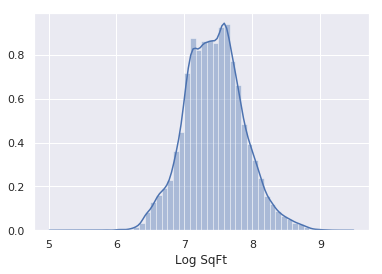

In [22]:
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
sns.distplot(df['Log SqFt'].dropna())

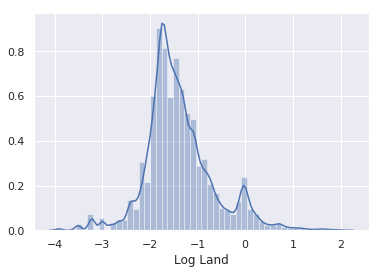

In [23]:
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
sns.distplot(df['Log Land'].dropna())

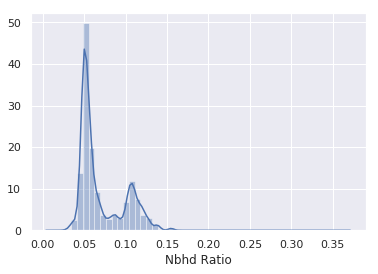

In [24]:
sns.distplot(df['Nbhd Ratio'].dropna())
df=df[df['Nbhd Ratio'] <= 0.3]

In [25]:
df.nlargest(10, 'Nbhd Ratio')['Neighborhood']

203808    4015
82509     6213
112819    2211
180687    6011
159814    6011
143683    6011
153896    9528
137965    9528
153549    9528
153568    9528
Name: Neighborhood, dtype: object

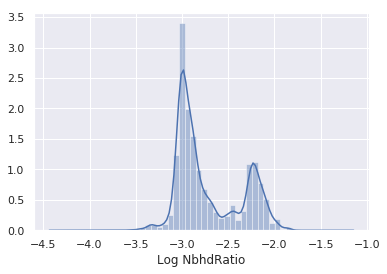

In [26]:
df['Log NbhdRatio']= df['Nbhd Ratio'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdRatio']=df['Log NbhdRatio'].replace(np.inf, np.nan)
sns.distplot(df['Log NbhdRatio'].dropna())

In [ ]:
meanpps.nlargest(20,'NeighborhoodPPS')

In [ ]:
df.loc[252586]

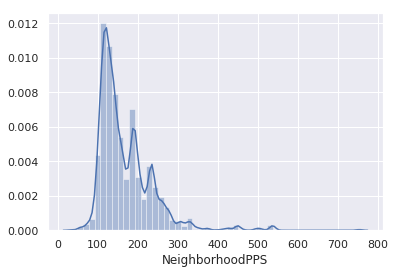

In [27]:
sns.distplot(df['NeighborhoodPPS'].dropna())
df=df[df.NeighborhoodPPS<=2000]

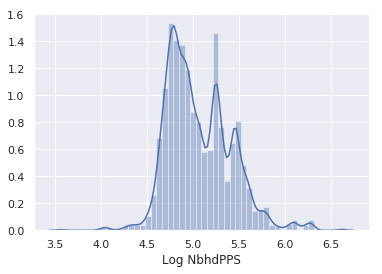

In [28]:
df['Log NbhdPPS']= df['NeighborhoodPPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']=df['Log NbhdPPS'].replace(np.inf, np.nan)
sns.distplot(df['Log NbhdPPS'].dropna())

In [30]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

In [60]:
df2 = df[['Log NbhdRatio','Building Condition','Log SqFt','Log Fixtures','Building Type Custom','Building Grade','Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 'Year Built']]
df2=df2.dropna()

In [61]:
from sklearn.model_selection import train_test_split
X= pd.get_dummies(df2[['Log NbhdPPS','Building Grade','Log SqFt','Year', 'Log Assessment','Log Fixtures','Exterior Wall', 'Year Built']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [62]:
print(df.shape)
print(df2.shape)

(53911, 80)
(53833, 13)


In [63]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

81.16381413563455


In [64]:
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

40.54999840844701


In [65]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


31.835844196123745


In [69]:
from xgboost import XGBRegressor as XGBR
#Best model parameters from GridSearchCV
model = XGBR(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

xgbr=model.fit(X_train,y_train)
y_predxg=xgbr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_predxg, y_test)**0.5)
print(MAE(y_predxg,y_test))
print(mean_absolute_error(y_predxg,y_test))

/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
29.956862358341137
11.98992481121438
19.155350941208503


<Figure size 648x648 with 0 Axes>

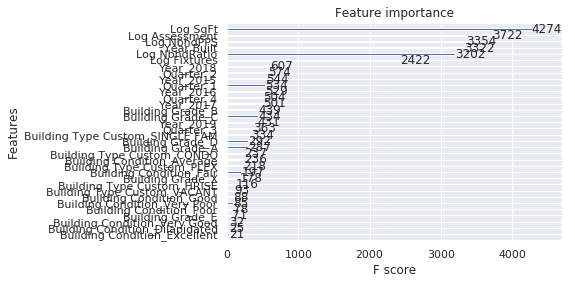

In [40]:
import xgboost as xgb
plt.figure(figsize=(9,9))
xgb.plot_importance(model)

In [ ]:
from sklearn.model_selection import GridSearchCV
params={'learning_rate':[.07,.08,.09]}
rfgrid = GridSearchCV(estimator = xgbr,param_grid=params, cv = 5, verbose=2, n_jobs = -1)
rfgrid.fit(X, y)

In [ ]:
print(MSE(y_test, rfgrid.best_estimator_.predict(X_test))**0.5) 
print(MAE(y_test, rfgrid.best_estimator_.predict(X_test)))
print(rfgrid.best_estimator_)

In [ ]:
gbm = lgb.LGBMRegressor(num_leaves=80,
                        learning_rate=0.25,
                        n_estimators=325)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=3)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

In [ ]:
np.sqrt(857.215)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import median_absolute_error as MAE
estimator = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': [0.18,0.21],
    'n_estimators': [500],
    'min_child_weight':[30,50],
    'max_depth': [5],
    'num_leaves': [350],
}
params={}
gbm = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
gbm.fit(X_train, y_train)
y_pred= gbm.predict(X_test)
print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)
print(MSE(y_pred,y_test)**0.5)
print(MAE(y_pred,y_test))

In [ ]:
gbm.best_estimator_

In [ ]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(gbm, y_train, y_test, cv=5)

## Examining where it went wrong

In [ ]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Residual'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

In [ ]:
df.loc[235871]

In [ ]:
#The pattern in my biggest flubs is, there's a big difference between the NeighborhoodPPS and the acutal PPS
#However, adding NeighborhoodPPS to the model significantly increases performance.
#So how can I tune it to accept NeighborhoodPPS while minimizing this error?
copiedxg.nlargest(20,'Residual')[['Log NbhdPPS', 'Actual', 'Predicted', 'Residual']]

In [ ]:
copied= X_test.copy()
copied['Actual']= y_test
copied['Predicted']= y_pred
copied['Residual'] = np.absolute(copied['Actual'] - copied['Predicted'])

In [ ]:
copied.nlargest(20, 'Residual')[['Actual','Predicted','Residual', 'Log NbhdPPS']]

In [ ]:
plt.figure(figsize=(9,9))
sns.distplot(copied.Residual.dropna())

In [ ]:
df.loc[235871]

In [ ]:
df.nlargest(15, 'PPS')[['Sale Price', 'Location', 'PPS', 'Square Footage Improved', 'Log Land']]

In [ ]:
import statsmodels.sm
test = pd.DataFrame({"prediction": pred, "observed": y_test.flatten()})

lowess = sm.nonparametric.lowess

z = lowess(pred.flatten(), y_test.flatten())


test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')

plt.title("Extreme Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")

plt.xlabel("Predicted Power Output", fontsize = 18) 

plt.ylabel("Observed Power Output", fontsize = 18)

plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)

plt.show()